**紅眼航班資料處理**

In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# 載入資料並刪除價格歷史為空的列
data = pd.read_csv('/Users/yuchingchen/Documents/專題/data/history/tokyo_history_1020.csv')
data = data[['航班代碼', '出發時間', '價格歷史']].dropna(subset=['價格歷史'])

# 設定參考日期
reference_date = datetime.strptime("10/20", "%m/%d")

# 判斷是否為紅眼航班的函數
def is_red_eye_flight(departure_time):
    if "凌晨" in departure_time:
        try:
            time_obj = datetime.strptime(departure_time.replace("凌晨", "").replace("。", ""), "%I:%M")
            return 1 if 0 <= time_obj.hour < 6 else 0
        except ValueError:
            return 0
    return 0

data['紅眼航班'] = data['出發時間'].apply(is_red_eye_flight)

# 處理價格歷史，將日期轉換為剩餘天數，並計算歷史價格平均、最低價格和變異
def process_price_history(history):
    entries = history.split(", ")
    remaining_days_with_prices = []
    prices = []
    
    for entry in entries:
        if "天前" in entry:
            days_ago = int(entry.split("天前")[0].strip())
            remaining_days = days_ago
            price = int(entry.split(" - ")[-1].replace("$", "").replace(",", ""))
        elif "今天" in entry:
            remaining_days = 0
            price = int(entry.split(" - ")[-1].replace("$", "").replace(",", ""))
        elif " - " in entry:
            date_str, price_str = entry.split(" - ")
            date_obj = datetime.strptime(date_str, "%m/%d")
            remaining_days = (reference_date - date_obj).days
            price = int(price_str.replace("$", "").replace(",", ""))
        else:
            continue

        remaining_days_with_prices.append((remaining_days, price))
        prices.append((price, remaining_days))
    
    # 計算平均價格
    avg_price = round(sum([p[0] for p in prices]) / len(prices)) if prices else None
    
    # 計算最低價格及其對應的剩餘天數
    if prices:
        min_price = min([p[0] for p in prices])
        min_days_left = [days for price, days in prices if price == min_price][-1]
    else:
        min_price, min_days_left = None, None
    
    # 計算價格的變異（標準差）
    price_variance = pd.Series([p[0] for p in prices]).std() if prices else None
    
    return remaining_days_with_prices, avg_price, min_price, min_days_left, price_variance

# 對每一行的價格歷史應用處理函數並新增歷史價格平均、最低價格、最低價格剩餘天數及變異欄位
data[['剩餘天數及價格', '歷史價格平均', '最低價格', '最低價格剩餘天數', '變異']] = data['價格歷史'].apply(lambda x: pd.Series(process_price_history(x)))

# 刪除不需要的原始價格歷史欄位
data = data[['航班代碼', '出發時間', '剩餘天數及價格', '歷史價格平均', '最低價格', '最低價格剩餘天數', '紅眼航班', '變異']]

# 顯示結果
print(data.head())

     航班代碼      出發時間                                            剩餘天數及價格  \
0  IT 202   下午1:30。  [(62, 5099), (61, 5099), (60, 5099), (59, 5099...   
1  SL 394  中午12:10。  [(59, 6159), (58, 6159), (57, 6159), (56, 6159...   
2  TR 874   下午2:50。  [(44, 4188), (43, 4188), (42, 4188), (41, 4188...   
3   GK 14  中午12:50。  [(50, 5889), (49, 5889), (48, 5889), (47, 5889...   
4  IT 700   下午2:45。  [(58, 3299), (57, 3299), (56, 3699), (55, 3699...   

   歷史價格平均    最低價格  最低價格剩餘天數  紅眼航班          變異  
0  4842.0  3699.0       4.0     0  305.523539  
1  5688.0  4495.0       6.0     0  935.627327  
2  4202.0  3588.0      18.0     0  337.545971  
3  4276.0  3589.0      17.0     0  894.640828  
4  4079.0  3299.0      57.0     0  397.912573  


**Boxplot**
平均價格跟最低價格跟最低價格剩餘天數跟變異（按是否紅眼航班分類）

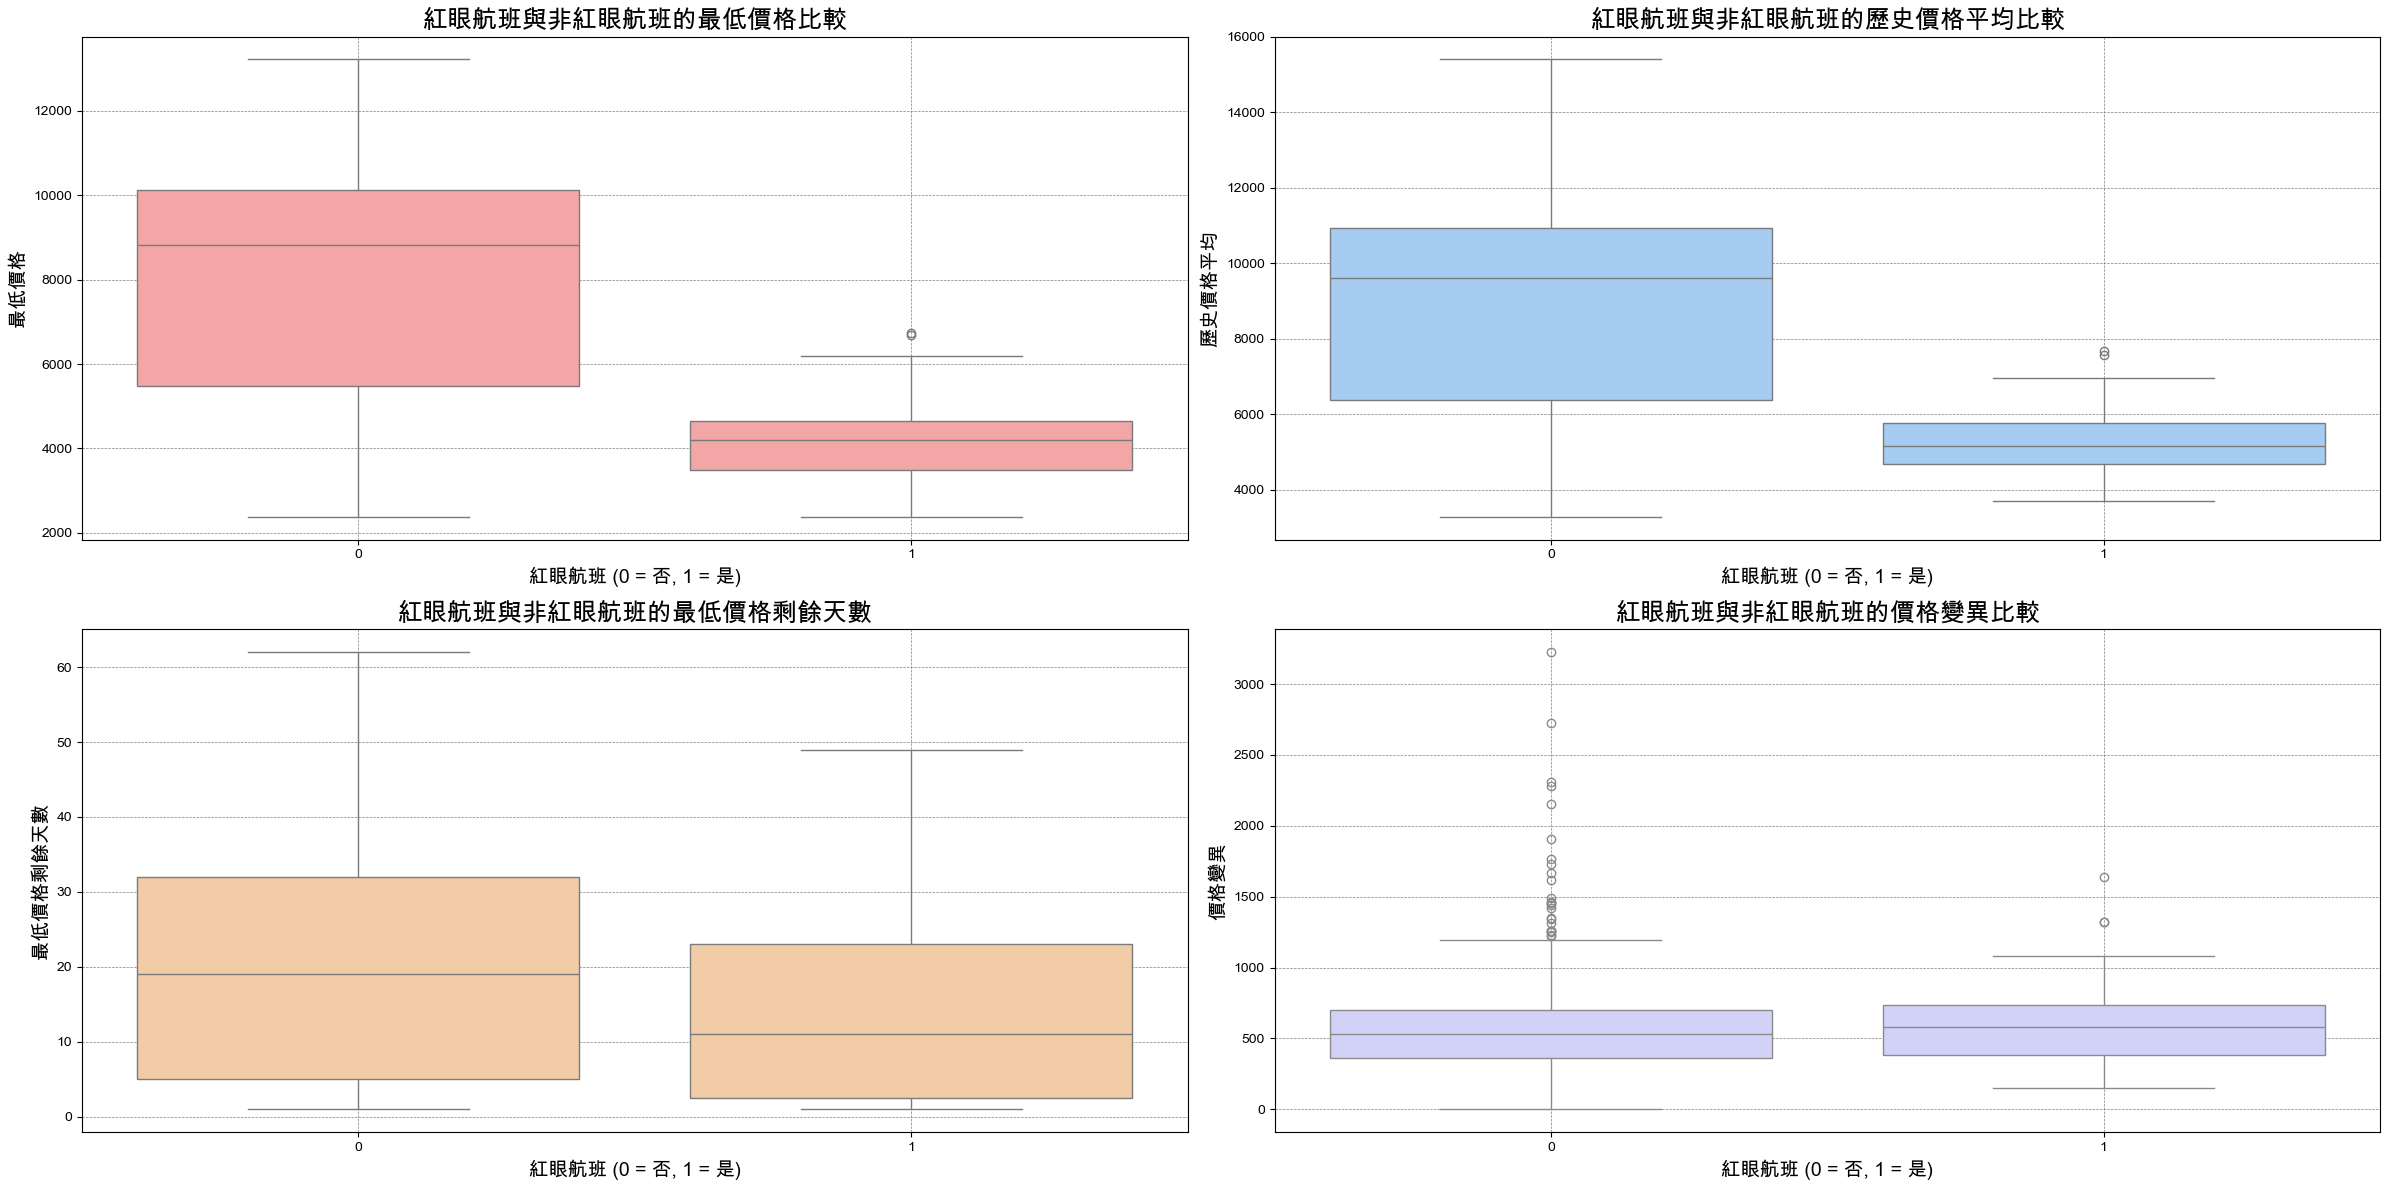

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# 繁體中文設定
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

# 去除缺失值的資料
plot_data = data.dropna(subset=['航班代碼', '最低價格', '最低價格剩餘天數', '歷史價格平均', '變異'])

# 創建子圖，分別繪製最低價格、歷史價格平均、最低價格剩餘天數和價格變異的盒狀圖
fig, axes = plt.subplots(2, 2, figsize=(24, 12))

# 調整圖表標題字體大小
title_fontsize = 18
label_fontsize = 14

# 第一個子圖：紅眼航班與非紅眼航班的最低價格的盒狀圖，使用自訂顏色
sns.boxplot(data=plot_data, x='紅眼航班', y='最低價格', ax=axes[0, 0], color='#FF9999')
axes[0, 0].set_title('紅眼航班與非紅眼航班的最低價格比較', fontsize=title_fontsize)
axes[0, 0].set_xlabel('紅眼航班 (0 = 否, 1 = 是)', fontsize=label_fontsize)
axes[0, 0].set_ylabel('最低價格', fontsize=label_fontsize)
axes[0, 0].grid(axis='y', color='gray', linestyle='--', linewidth=0.5)

# 第二個子圖：紅眼航班與非紅眼航班的歷史價格平均的盒狀圖，使用不同顏色
sns.boxplot(data=plot_data, x='紅眼航班', y='歷史價格平均', ax=axes[0, 1], color='#99CCFF')
axes[0, 1].set_title('紅眼航班與非紅眼航班的歷史價格平均比較', fontsize=title_fontsize)
axes[0, 1].set_xlabel('紅眼航班 (0 = 否, 1 = 是)', fontsize=label_fontsize)
axes[0, 1].set_ylabel('歷史價格平均', fontsize=label_fontsize)
axes[0, 1].grid(axis='y', color='gray', linestyle='--', linewidth=0.5)

# 第三個子圖：紅眼航班與非紅眼航班的最低價格剩餘天數的盒狀圖，使用另一種顏色
sns.boxplot(data=plot_data, x='紅眼航班', y='最低價格剩餘天數', ax=axes[1, 0], color='#FFCC99')
axes[1, 0].set_title('紅眼航班與非紅眼航班的最低價格剩餘天數', fontsize=title_fontsize)
axes[1, 0].set_xlabel('紅眼航班 (0 = 否, 1 = 是)', fontsize=label_fontsize)
axes[1, 0].set_ylabel('最低價格剩餘天數', fontsize=label_fontsize)
axes[1, 0].grid(axis='y', color='gray', linestyle='--', linewidth=0.5)

# 第四個子圖：紅眼航班與非紅眼航班的價格變異的盒狀圖，使用另一種顏色
sns.boxplot(data=plot_data, x='紅眼航班', y='變異', ax=axes[1, 1], color='#CCCCFF')
axes[1, 1].set_title('紅眼航班與非紅眼航班的價格變異比較', fontsize=title_fontsize)
axes[1, 1].set_xlabel('紅眼航班 (0 = 否, 1 = 是)', fontsize=label_fontsize)
axes[1, 1].set_ylabel('價格變異', fontsize=label_fontsize)
axes[1, 1].grid(axis='y', color='gray', linestyle='--', linewidth=0.5)

# 移除多餘的格線
for ax in axes.flat:
    ax.grid(axis='x', color='gray', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

**Histogram**
平均價格跟最低價格跟最低價格剩餘天數跟變異

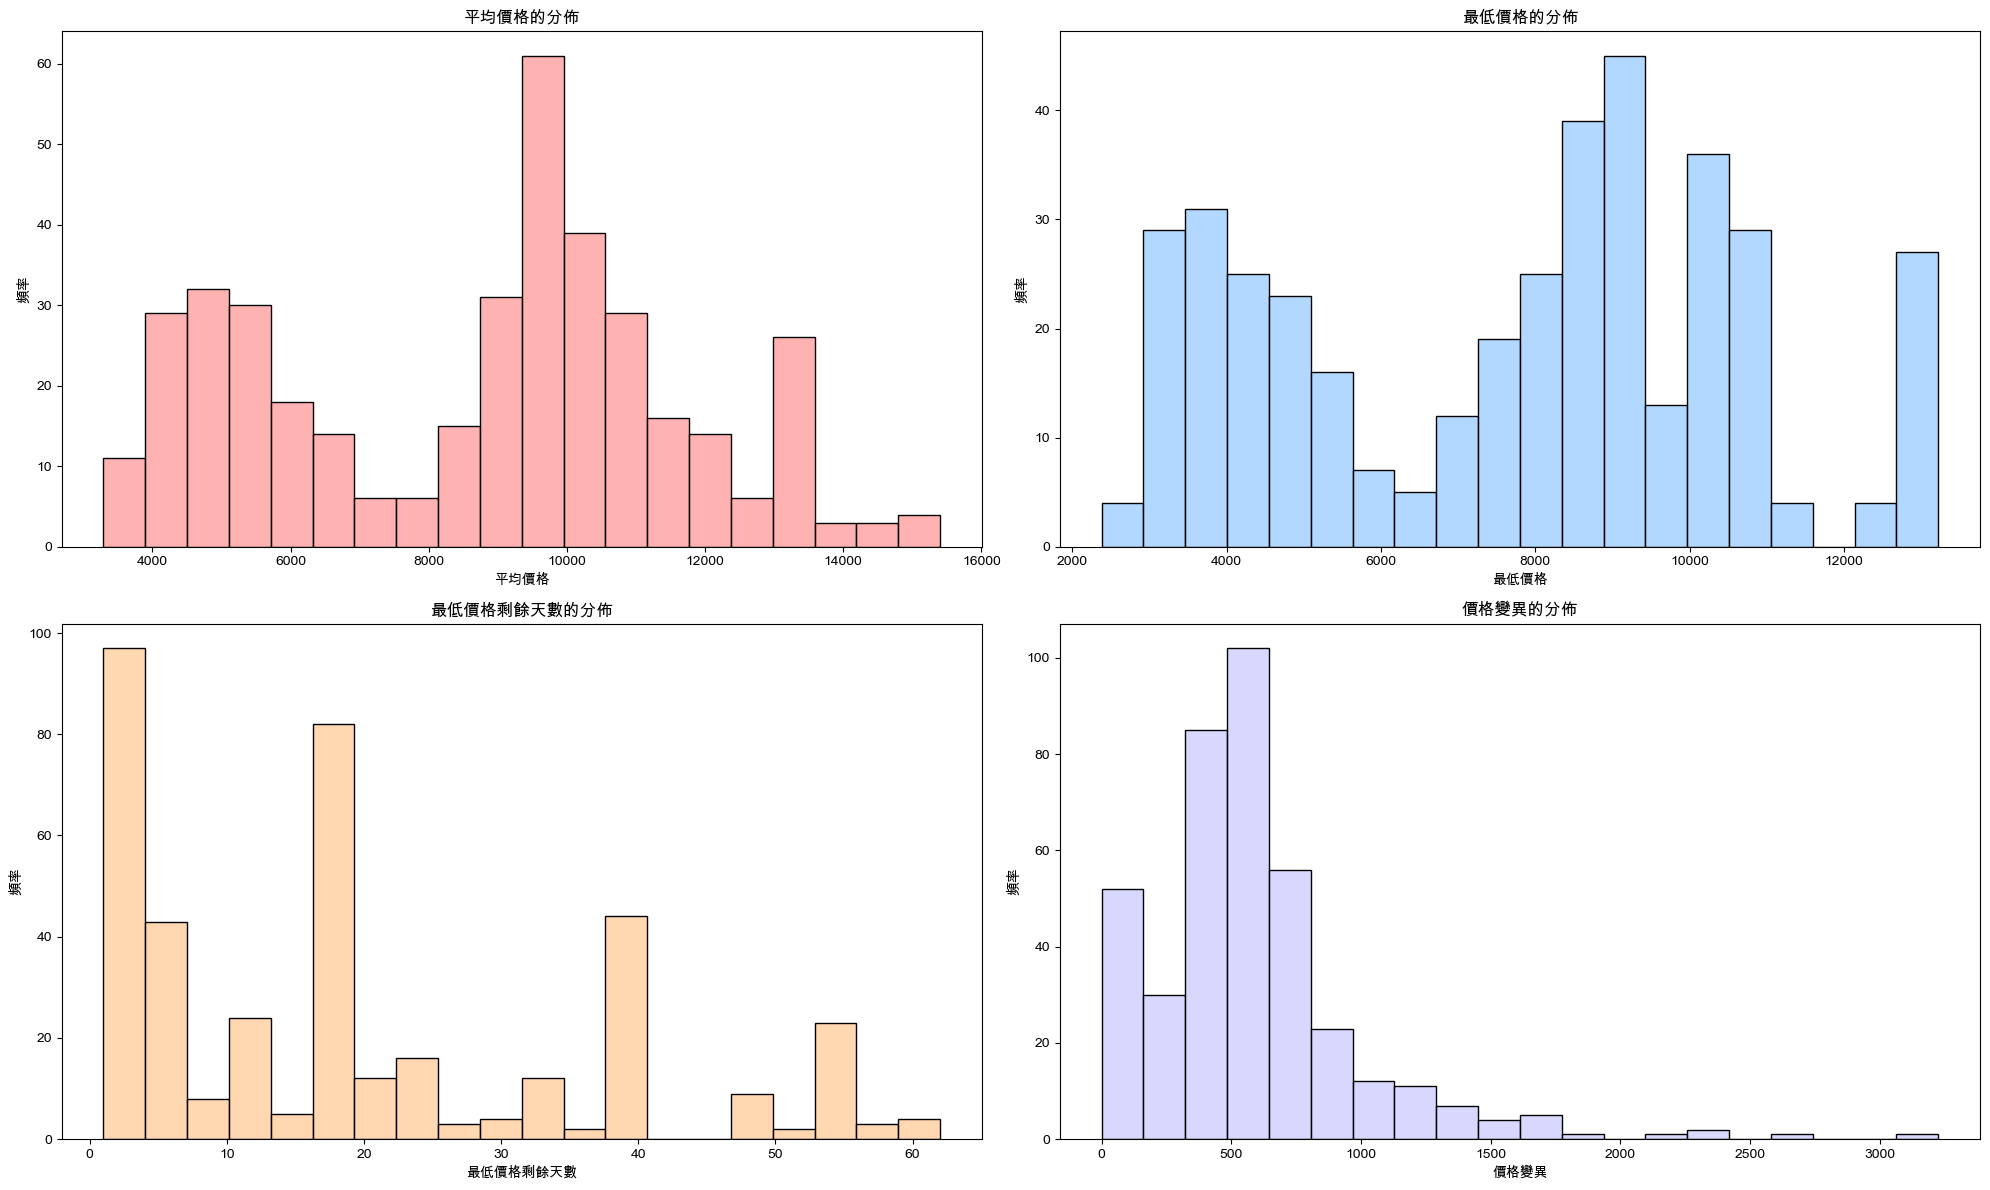

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# 繁體中文設定
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

# 去除缺失值的資料
plot_data = data.dropna(subset=['歷史價格平均', '最低價格', '最低價格剩餘天數', '變異'])

# 創建子圖，分別繪製平均價格、最低價格、最低價格剩餘天數和價格變異的直方圖
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
bins = 20  # 設定直方圖的 bin 數量

# 第一個子圖：平均價格的直方圖
sns.histplot(plot_data['歷史價格平均'], bins=bins, kde=False, color='#FF9999', ax=axes[0, 0])
axes[0, 0].set_title('平均價格的分佈')
axes[0, 0].set_xlabel('平均價格')
axes[0, 0].set_ylabel('頻率')

# 第二個子圖：最低價格的直方圖
sns.histplot(plot_data['最低價格'], bins=bins, kde=False, color='#99CCFF', ax=axes[0, 1])
axes[0, 1].set_title('最低價格的分佈')
axes[0, 1].set_xlabel('最低價格')
axes[0, 1].set_ylabel('頻率')

# 第三個子圖：最低價格剩餘天數的直方圖
sns.histplot(plot_data['最低價格剩餘天數'], bins=bins, kde=False, color='#FFCC99', ax=axes[1, 0])
axes[1, 0].set_title('最低價格剩餘天數的分佈')
axes[1, 0].set_xlabel('最低價格剩餘天數')
axes[1, 0].set_ylabel('頻率')

# 第四個子圖：價格變異的直方圖
sns.histplot(plot_data['變異'], bins=bins, kde=False, color='#CCCCFF', ax=axes[1, 1])
axes[1, 1].set_title('價格變異的分佈')
axes[1, 1].set_xlabel('價格變異')
axes[1, 1].set_ylabel('頻率')

# 調整佈局
plt.tight_layout()
plt.show()

**常態檢定**

In [11]:
from scipy.stats import shapiro

# 定義變數名稱和對應的數據
variables = {
    '平均價格': plot_data['歷史價格平均'],
    '最低價格': plot_data['最低價格'],
    '最低價格剩餘天數': plot_data['最低價格剩餘天數'],
    '價格變異': plot_data['變異']
}

# 對每個變數進行 Shapiro-Wilk 檢定
for var_name, data in variables.items():
    stat, p_value = shapiro(data)
    print(f"{var_name} 的 Shapiro-Wilk 檢定 P 值: {p_value}")
    if p_value > 0.05:
        print(f"{var_name} 接近正態分佈")
    else:
        print(f"{var_name} 顯著偏離正態分佈")

平均價格 的 Shapiro-Wilk 檢定 P 值: 1.769379175812372e-10
平均價格 顯著偏離正態分佈
最低價格 的 Shapiro-Wilk 檢定 P 值: 1.1366619877177843e-10
最低價格 顯著偏離正態分佈
最低價格剩餘天數 的 Shapiro-Wilk 檢定 P 值: 4.701058573677168e-17
最低價格剩餘天數 顯著偏離正態分佈
價格變異 的 Shapiro-Wilk 檢定 P 值: 1.2408179838502701e-18
價格變異 顯著偏離正態分佈


**顯著偏離正態分佈 用 Kruskal-Wallis Test**

In [12]:
from scipy.stats import kruskal

# 分別選取紅眼航班和非紅眼航班的各變數數據
red_eye_prices_avg = plot_data[plot_data['紅眼航班'] == 1]['歷史價格平均']
non_red_eye_prices_avg = plot_data[plot_data['紅眼航班'] == 0]['歷史價格平均']

red_eye_min_price = plot_data[plot_data['紅眼航班'] == 1]['最低價格']
non_red_eye_min_price = plot_data[plot_data['紅眼航班'] == 0]['最低價格']

red_eye_min_days_left = plot_data[plot_data['紅眼航班'] == 1]['最低價格剩餘天數']
non_red_eye_min_days_left = plot_data[plot_data['紅眼航班'] == 0]['最低價格剩餘天數']

red_eye_variance = plot_data[plot_data['紅眼航班'] == 1]['變異']
non_red_eye_variance = plot_data[plot_data['紅眼航班'] == 0]['變異']

# Kruskal-Wallis 檢定對每個變數進行
variables = {
    '平均價格': (red_eye_prices_avg, non_red_eye_prices_avg),
    '最低價格': (red_eye_min_price, non_red_eye_min_price),
    '最低價格剩餘天數': (red_eye_min_days_left, non_red_eye_min_days_left),
    '價格變異': (red_eye_variance, non_red_eye_variance)
}

for var_name, (red_eye_data, non_red_eye_data) in variables.items():
    stat, p_value = kruskal(red_eye_data, non_red_eye_data)
    print(f"{var_name} 的 Kruskal-Wallis 檢定 P 值: {p_value}")
    if p_value < 0.05:
        print(f"{var_name} 在紅眼航班與非紅眼航班之間有顯著差異")
    else:
        print(f"{var_name} 在紅眼航班與非紅眼航班之間沒有顯著差異")

平均價格 的 Kruskal-Wallis 檢定 P 值: 1.891410634020513e-12
平均價格 在紅眼航班與非紅眼航班之間有顯著差異
最低價格 的 Kruskal-Wallis 檢定 P 值: 4.3401917611406486e-14
最低價格 在紅眼航班與非紅眼航班之間有顯著差異
最低價格剩餘天數 的 Kruskal-Wallis 檢定 P 值: 0.08630828522018535
最低價格剩餘天數 在紅眼航班與非紅眼航班之間沒有顯著差異
價格變異 的 Kruskal-Wallis 檢定 P 值: 0.33431650156415754
價格變異 在紅眼航班與非紅眼航班之間沒有顯著差異


**比較平均價格和最低價格的差異**

In [13]:
red_eye_avg_mean = plot_data[plot_data['紅眼航班'] == 1]['歷史價格平均'].mean()
non_red_eye_avg_mean = plot_data[plot_data['紅眼航班'] == 0]['歷史價格平均'].mean()

red_eye_min_mean = plot_data[plot_data['紅眼航班'] == 1]['最低價格'].mean()
non_red_eye_min_mean = plot_data[plot_data['紅眼航班'] == 0]['最低價格'].mean()

print(f"紅眼航班的平均價格: {red_eye_avg_mean}, 非紅眼航班的平均價格: {non_red_eye_avg_mean}")
print(f"紅眼航班的最低價格: {red_eye_min_mean}, 非紅眼航班的最低價格: {non_red_eye_min_mean}")

紅眼航班的平均價格: 5294.410256410257, 非紅眼航班的平均價格: 9017.661016949152
紅眼航班的最低價格: 4186.307692307692, 非紅眼航班的最低價格: 8109.336158192091


**Boxplot/Histogram**
平均價格跟最低價格（按是否紅眼航班分類）

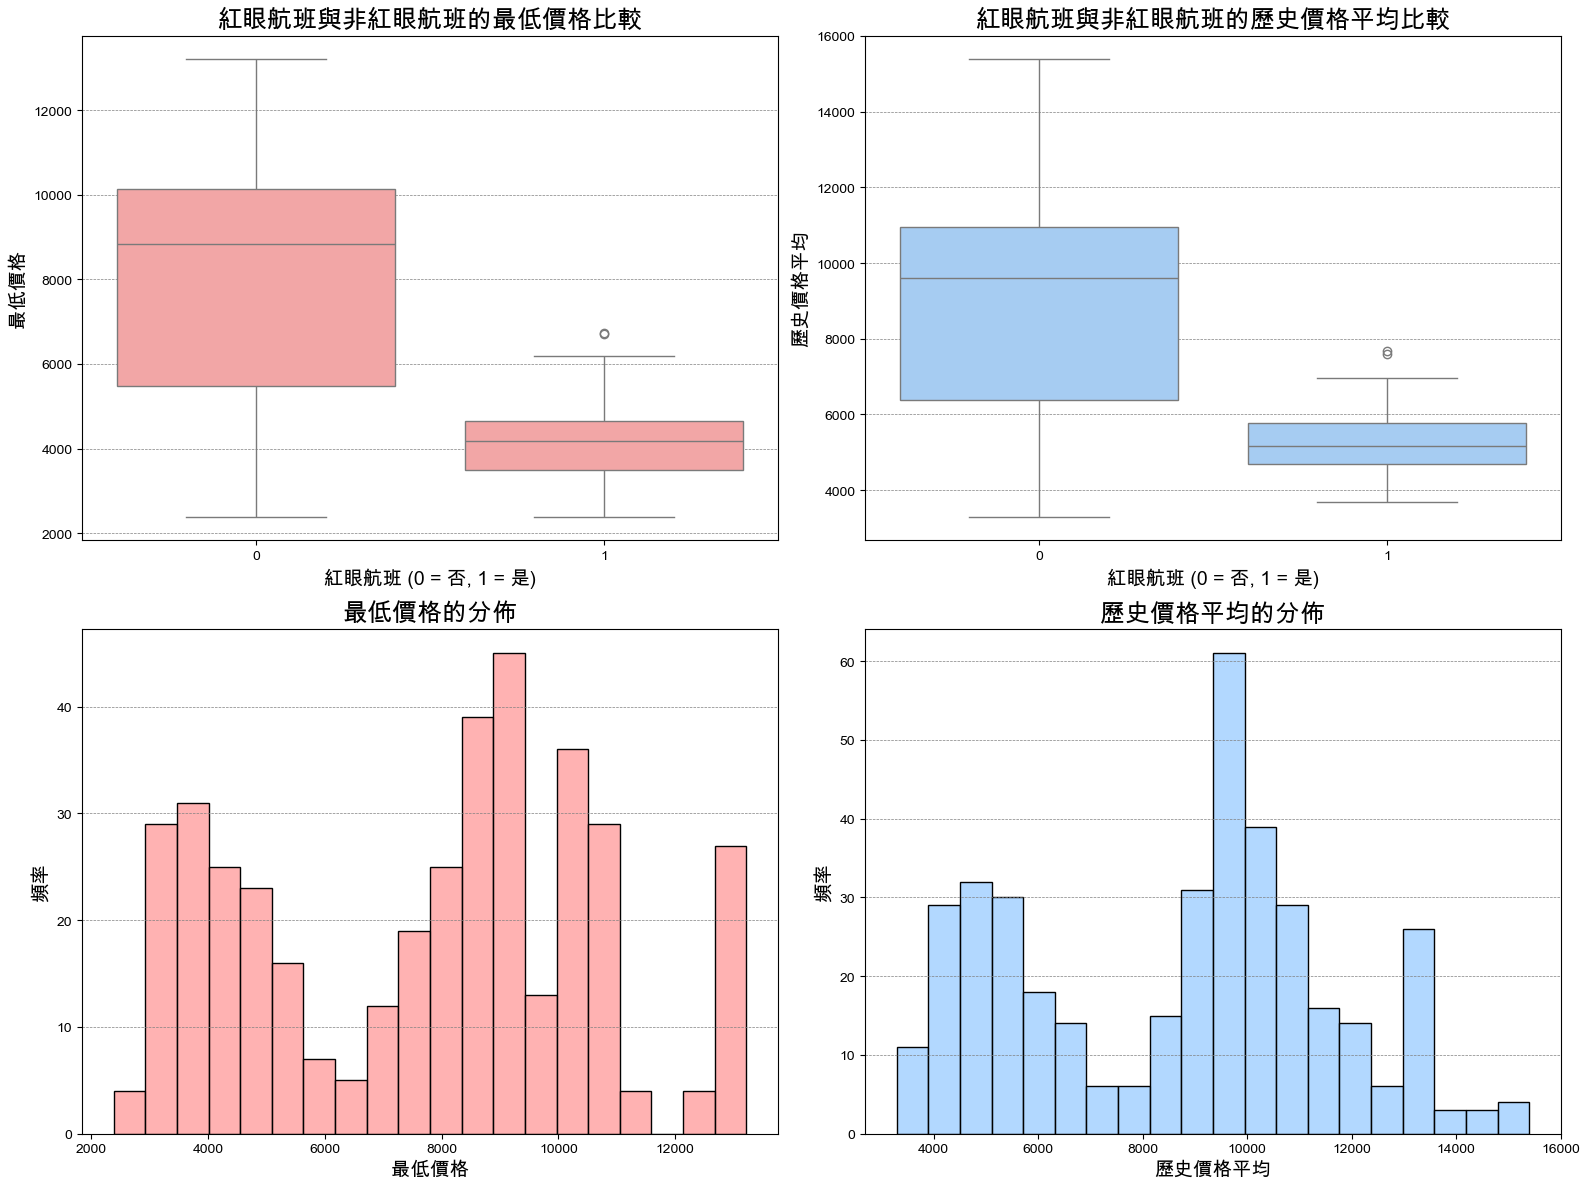

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# 繁體中文設定
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

# 創建 2x2 子圖
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 設定字體大小
title_fontsize = 18
label_fontsize = 14

# 第一個子圖：紅眼航班與非紅眼航班的最低價格的盒狀圖
sns.boxplot(data=plot_data, x='紅眼航班', y='最低價格', ax=axes[0, 0], color='#FF9999')
axes[0, 0].set_title('紅眼航班與非紅眼航班的最低價格比較', fontsize=title_fontsize)
axes[0, 0].set_xlabel('紅眼航班 (0 = 否, 1 = 是)', fontsize=label_fontsize)
axes[0, 0].set_ylabel('最低價格', fontsize=label_fontsize)
axes[0, 0].grid(axis='y', color='gray', linestyle='--', linewidth=0.5)

# 第二個子圖：紅眼航班與非紅眼航班的歷史價格平均的盒狀圖
sns.boxplot(data=plot_data, x='紅眼航班', y='歷史價格平均', ax=axes[0, 1], color='#99CCFF')
axes[0, 1].set_title('紅眼航班與非紅眼航班的歷史價格平均比較', fontsize=title_fontsize)
axes[0, 1].set_xlabel('紅眼航班 (0 = 否, 1 = 是)', fontsize=label_fontsize)
axes[0, 1].set_ylabel('歷史價格平均', fontsize=label_fontsize)
axes[0, 1].grid(axis='y', color='gray', linestyle='--', linewidth=0.5)

# 第三個子圖：最低價格的直方圖
sns.histplot(plot_data['最低價格'], kde=False, color='#FF9999', ax=axes[1, 0], bins=20)
axes[1, 0].set_title('最低價格的分佈', fontsize=title_fontsize)
axes[1, 0].set_xlabel('最低價格', fontsize=label_fontsize)
axes[1, 0].set_ylabel('頻率', fontsize=label_fontsize)
axes[1, 0].grid(axis='y', color='gray', linestyle='--', linewidth=0.5)

# 第四個子圖：歷史價格平均的直方圖
sns.histplot(plot_data['歷史價格平均'], kde=False, color='#99CCFF', ax=axes[1, 1], bins=20)
axes[1, 1].set_title('歷史價格平均的分佈', fontsize=title_fontsize)
axes[1, 1].set_xlabel('歷史價格平均', fontsize=label_fontsize)
axes[1, 1].set_ylabel('頻率', fontsize=label_fontsize)
axes[1, 1].grid(axis='y', color='gray', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

1.	最低價格比較：
	•	紅眼航班的最低價格（1）分佈較低，大多集中在 4000 到 6000 的區間，且價格波動較小。
	•	非紅眼航班的最低價格（0）則分佈較廣，且整體價格偏高，價格集中在 6000 到 10000 之間。
2.	歷史價格平均比較：
	•	紅眼航班的平均價格同樣顯著低於非紅眼航班，分佈集中在較低的區間（4000 到 6000 左右），且價格波動較小。
	•	非紅眼航班的平均價格偏高，分佈範圍也較大，顯示出較大的價格波動。

這些圖表進一步支持了紅眼航班的價格顯著低於非紅眼航班的結論。